In [39]:
import sys
import sklearn
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# 투표 기반 분류기

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

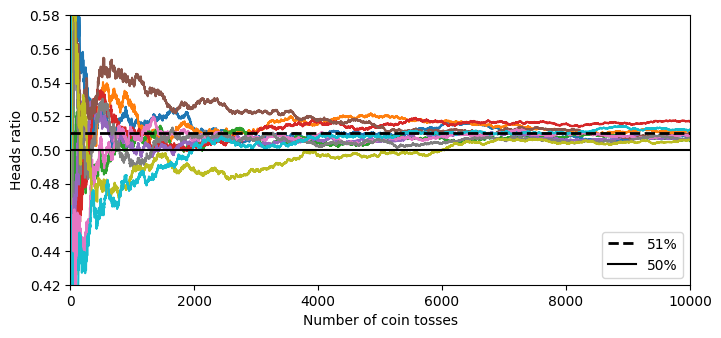

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

코인의 앞면이 나올 확율이 51%인 동전을 던진다면 위와 같이 초반에는 앞면이 나올 확률이 51%가 안나올 경우가 많이 나온다.

하지만 큰 수의 법칙에 의해서 시행 횟수를 많이 늘려주게 된다면 나중에는 확률이 51%로 수렴하는 것을 볼 수 있다.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
# make_moons데이터를 투표 기반 분류기로 학습 - 직접투표

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

voting_clf에는 각각 로지스틱 회귀, 랜덤 포레스트, SVM 3가지 분류기가 들어있다.

이를 통해서 각각의 분류기로 예측을 한 뒤 가장 많이 옳다고 한 것을 결괏값으로 예측한다.

아래를 비교해보면 각각 0.864, 0.896, 0.896으로 정확도가 나왔지만 이들을 투표를 통해 나온 결과는 0.912로 정확도가 상승한 것을 볼 수 있다.

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [7]:
# make_moons데이터를 투표 기반 분류기로 학습 - 간접투표

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [8]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


간접투표로 결과를 예측한 결과 직접투표와 비교하였을 때 정확도가 0.912에서 0.92로 높아진것을 볼 수 있다.

In [18]:
# 배깅을 사용해서 make_moons데이터 예측

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

In [19]:
# 페이스팅을 사용해서 make_moons데이터 예측

pasting_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=False, random_state=42)
pasting_clf.fit(X_train, y_train)
y_pred = pasting_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

In [31]:
# 결정 트리를 사용해서 make_moons데이터 예측

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
accuracy_score(y_test, y_pred_tree)

0.856

배깅과 페이스팅을 사용하여 분류기를 여러개 만들어 학습을 하면 단일 분류기를 사용한 결과보다 확실히 더 좋은 결과가 나온것을 볼 수 있다

In [14]:
# 결정 트리와 배깅 앙상블 비교

from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

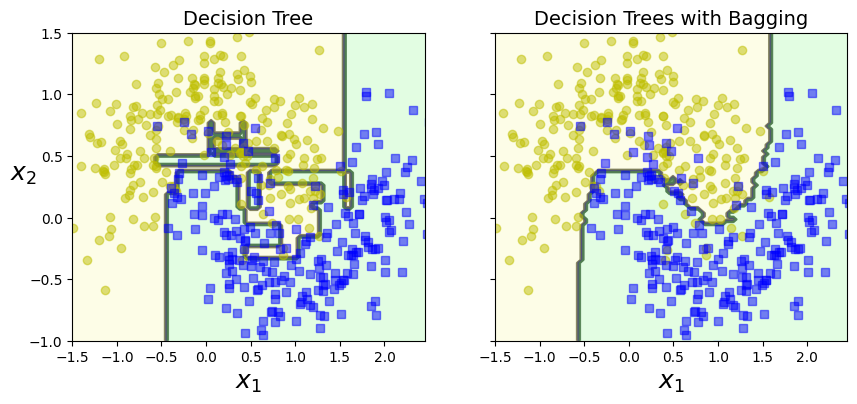

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

plt.show()

결정 트리로 학습한 모델은 왼쪽과 같이 결정 경계가 과적합 하게 형성이 되어 일반화가 떨어진다.

반면에 bagging을 활용하여 500개의 트리를 앙상블 하여 만든 모델은 분산을 줄여 일반화가 잘 된 모델을 만들었다.

아래를 보면 15개의 결정 트리의 결정 경계를 중첩한 그래프를 시각화 하였다.

이를 보면 하나의 결정 경계를 보면 과적합한 부분이 많아 좋지 못하지만 앙상블을 통해서 이상치에 해당하는 부분은 제거 되면서 일반화성이 높은 형태의 모델로 훈련이 되는것을 볼 수 있다.

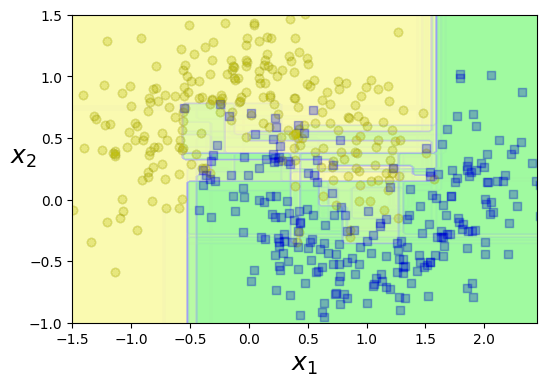

In [34]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

In [22]:
# oob 평가

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

oob 평가를 사용하여 학습에 사용되지 않은 데이터를 이용해 bagging앙상블의 정확도를 높였다.

In [32]:
# 랜덤 포레스트를 사용해서 make_moons데이터 예측

from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.912

In [33]:
# 특성의 중요도

from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


랜덤 포레스트를 사용하면 특성별 상대적 중요도를 측정하기 쉽다.

따라서 iris데이터에서 각각의 특성에 대하여 중요도를 위와 같이 수치적으로 표현할 수 있다.

이를 통해서 꽃잎의 너비와 길이가 중요한 특성임을 알 수 있고, 상대적으로 꽃받침의 길이와 너비는 중요도가 낮음을 알 수 있다.

In [35]:
# mnist 데이터를 이용한 특성의 중요도

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, parser="auto")
mnist.target = mnist.target.astype(np.uint8)

In [36]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [40]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

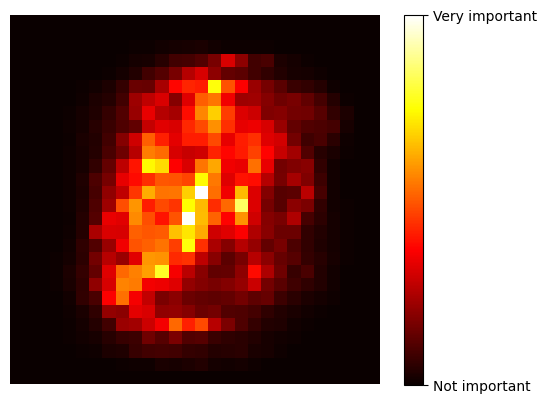

In [41]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

위의 결과를 통해서 mnist데이터를 학습할 때 상대적으로 중심의 있는 픽셀이 숫자를 결정할 때 중요한 역할을 하고 주변에 있는 픽셀은 영향이 적다는 것을 볼 수 있다.

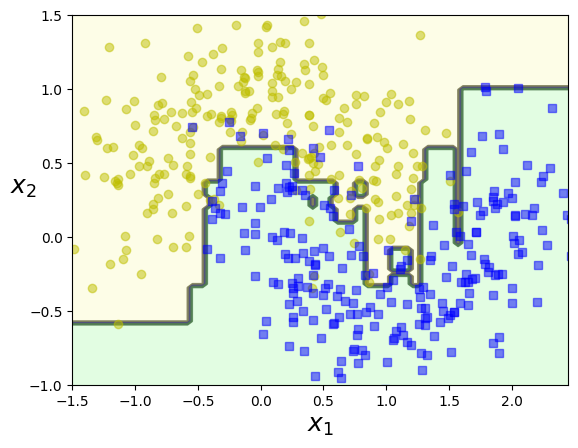

In [44]:
# 에이다부스트를 사용해서 make_moons데이터 예측

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
plot_decision_boundary(ada_clf, X, y)
plt.show()

<span style="font-size:15px">
    
가중치가 적용된 에러율 : $r_i = \frac{\sum\limits_{i = 1, \hat y_j^{(i)}\neq y_j^{(i)}}^m w^{(i)}  }{\sum\limits_{i = 1}^m w^{(i)}}$
    
예측기의 가중치 : $\alpha_j = \eta \log \frac{1 - r_j}{r_j}$
    
가중치 업데이트 규칙 :
$$
w^{(i)} =
\begin{cases}
w^{(i)} & \mbox{if } \hat y_j^{(i)} = y_j^{(i)}  \\
w^{(i)} \exp(\alpha_j) & \mbox{if } \hat y_j^{(i)} \neq y_j^{(i)}
\end{cases}
$$

</span>

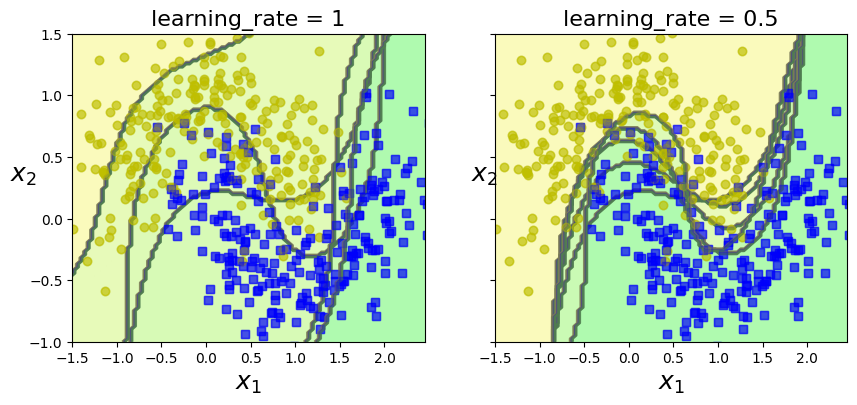

In [47]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum()
        alpha = learning_rate * np.log((1 - r) / r)
        sample_weights[y_pred != y_train] *= np.exp(alpha) 
        sample_weights /= sample_weights.sum()
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
        
plt.show()

In [48]:
# 그레디언트 부스팅

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100) # y = 3x^2에 노이즈 추가한 100개의 샘플

In [49]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [91]:
X_new = np.array([[0.4]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.49995198])

첫 번째 예측기에서 생긴 잔여 오차를 두 번째 DecisionTreeRegressor에서 훈련 시켰다.

그리고 두 번째 예측기에서 생긴 잔여 오차를 세 번째 회귀 모델에서 훈련하여 그레디언트 부스팅 모델을 만들었다.

그리고 값의 예측을 위해서는 샘플에 대하여 모든 트리에서의 예측을 합하면 결괏값이 나온다.


In [92]:
# 각각의 트리의 예측과 앙상블 예측 시각화

def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

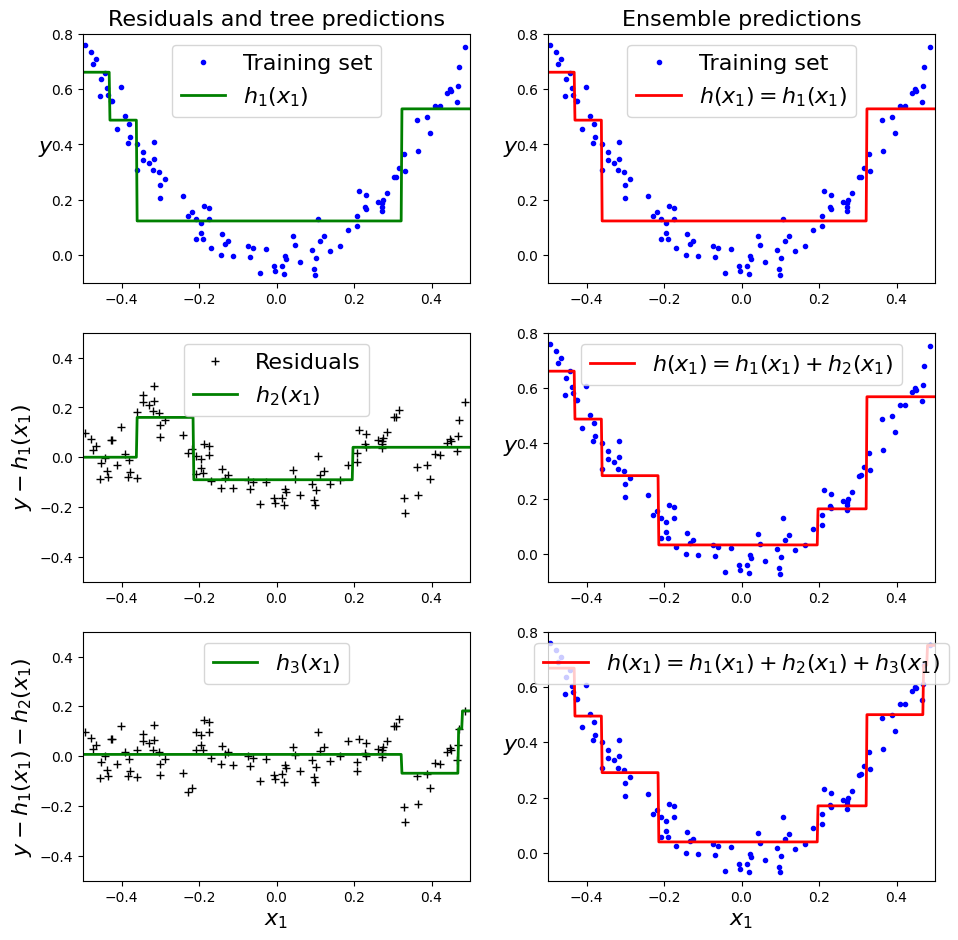

In [93]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.show()

위 그래프를 보면 첫 번째 예측기를 통과한 결과는 오차가 크게 발생하였다.

따라서 해당 오차에 가중치를 부여해 두 번째 예측기를 통과시켜서 잔여 오차에 대하여 학습을 하였다.

같은 방식으로 또 한 번 더 진행시켜서 앙상블 예측을 향상시켰다.

In [94]:
# learning_rate에 따른 그래디언트 부스팅 앙상블 비교

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

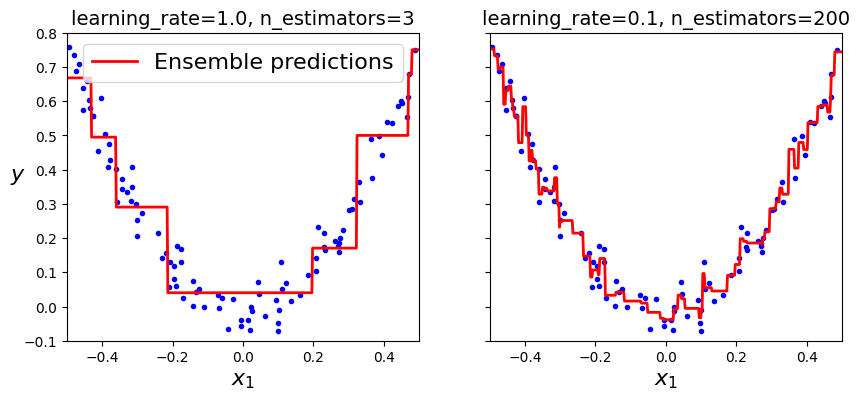

In [95]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.show()

왼쪽처럼 learning_rate를 너무 높게 잡은 경우 샘플에 과소적합한 형태의 모델이 나옴을 볼 수 있다.

반면 오른쪽처럼 learning_rate를 너무 낮게 잡으면 샘플에 과대적합하여 일반화성능이 떨어지는 모델이 학습되게 된다.

이러한 경우를 해결하기 위해 아래처럼 조기 종료를 사용하여 규제를 하면 좋다.

In [102]:
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)
min_error = np.min(errors)

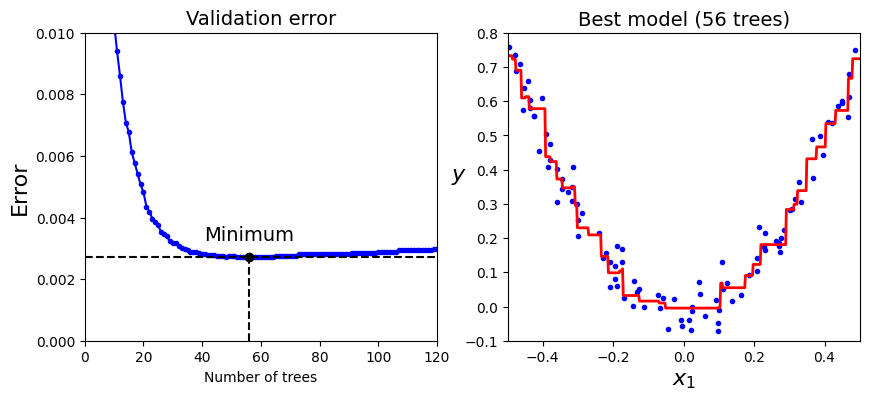

In [103]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)
plt.show()

이처럼 조기 종료를 사용하면 최적의 에러를 가지는 56개의 트리를 사용했을 때의 모델을 구할 수 있다.

조기 종료를 사용할 때는 최솟값에 도달할 때 바로 멈출 경우 지역 최솟값에서 멈출 수 있다.

따라서 아래와 같이 연속으로 일정 횟수만큼 검증 오차가 향상되지 않을 경우에 훈련을 멈추는 것이 더 좋다.

In [106]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break
gbrt.n_estimators

61

In [107]:
!pip install xgboost

In [109]:
# XGBoost사용해서 모델 학습하기

import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred) 
print("Validation MSE:", val_error)   

Validation MSE: 0.004644479346317078


In [110]:
# validation set 사용하여 XGBoost 조기종료 

xgb_reg = xgboost.XGBRegressor(random_state=42, early_stopping_rounds=2)
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)])
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)  
print("Validation MSE:", val_error)            

[0]	validation_0-rmse:0.15232
[1]	validation_0-rmse:0.10690
[2]	validation_0-rmse:0.07868
[3]	validation_0-rmse:0.06385
[4]	validation_0-rmse:0.05656
[5]	validation_0-rmse:0.05486
[6]	validation_0-rmse:0.05394
[7]	validation_0-rmse:0.05556
[8]	validation_0-rmse:0.05682
Validation MSE: 0.0029091166440151123


In [111]:
# XGBoost와 그래디언트 부스팅 속도 비교

%timeit xgboost.XGBRegressor().fit(X_train, y_train)

25 ms ± 5.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [112]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

41.5 ms ± 2.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
